# Lab 3 — recommender systems

In [19]:
import json
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import pickle
import pyspark.mllib.recommendation as ml
from pyspark.sql.functions import sqrt
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool
import rate_movies
output_notebook()

%matplotlib inline
plt.style.use("ggplot")

Loading BokehJS ...

## Raw Data Visualization

Before jumping in the exercices, let's see a bit how does the data look like!

In [20]:
data = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)

In [21]:
N = data.count()
some_ratings = data.take(10)
print(f"The total number of ratings is {N}, and some data entries look like so : ")
for i, rating in enumerate(some_ratings):
    print("%d: %s" % (i, rating))

The total number of ratings is 20000263, and some data entries look like so : 
0: {'movieId': 2, 'userId': 1, 'timestamp': 1112486027, 'rating': 3.5}
1: {'movieId': 29, 'userId': 1, 'timestamp': 1112484676, 'rating': 3.5}
2: {'movieId': 32, 'userId': 1, 'timestamp': 1112484819, 'rating': 3.5}
3: {'movieId': 47, 'userId': 1, 'timestamp': 1112484727, 'rating': 3.5}
4: {'movieId': 50, 'userId': 1, 'timestamp': 1112484580, 'rating': 3.5}
5: {'movieId': 112, 'userId': 1, 'timestamp': 1094785740, 'rating': 3.5}
6: {'movieId': 151, 'userId': 1, 'timestamp': 1094785734, 'rating': 4.0}
7: {'movieId': 223, 'userId': 1, 'timestamp': 1112485573, 'rating': 4.0}
8: {'movieId': 253, 'userId': 1, 'timestamp': 1112484940, 'rating': 4.0}
9: {'movieId': 260, 'userId': 1, 'timestamp': 1112484826, 'rating': 4.0}


**Should we clear the database and if yes, how ?**

## Ex 3.4)

Now we will try to get some basic statistics on this dataset to have a better idea of how the ratings are distributed among users and movies.

### User

In [22]:
count_per_user = data.map(lambda rating : (rating["userId"],1))
count_per_user = count_per_user.reduceByKey(lambda a,b : a+b).sortByKey()
rating_per_user = np.asarray(count_per_user.map(lambda u : u[1]).collect())

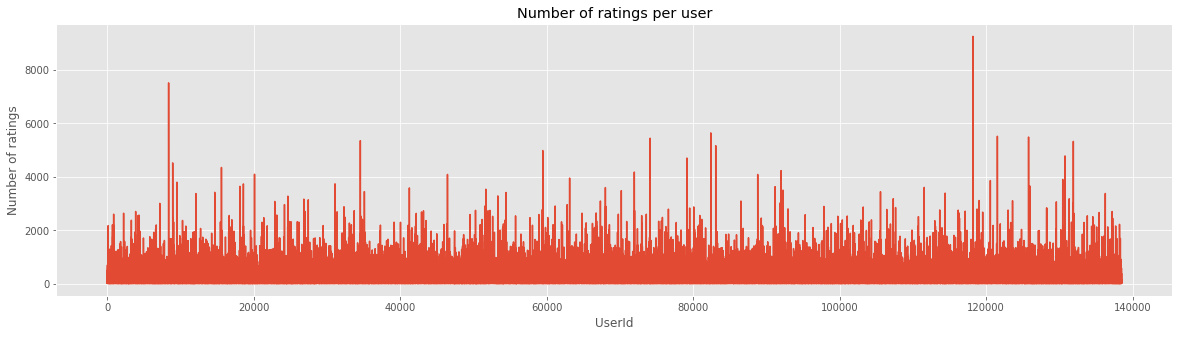

In [23]:
fig, ax = plt.subplots(figsize=(20,5))
ax.set_title('Number of ratings per user')
ax.set_ylabel("Number of ratings")
ax.set_xlabel("UserId")
plot_users = ax.plot(rating_per_user)

In [24]:
user_mean = rating_per_user.mean()
user_std = rating_per_user.std()
print(f"There is {len(rating_per_user)} users. The mean number of ratings per user is {user_mean} and it has a standard deviation of {user_std}")

There is 138493 users. The mean number of ratings per user is 144.4135299257002 and it has a standard deviation of 230.26642566347996


There is a pretty strong variance and the mean is pretty low compared to some peaks that we can observe. Thus there is clearly some outliers, i.e. users who have rated a lot of films or who have rated only a few. Let's do a boxlplot to have a better view of these outliers:

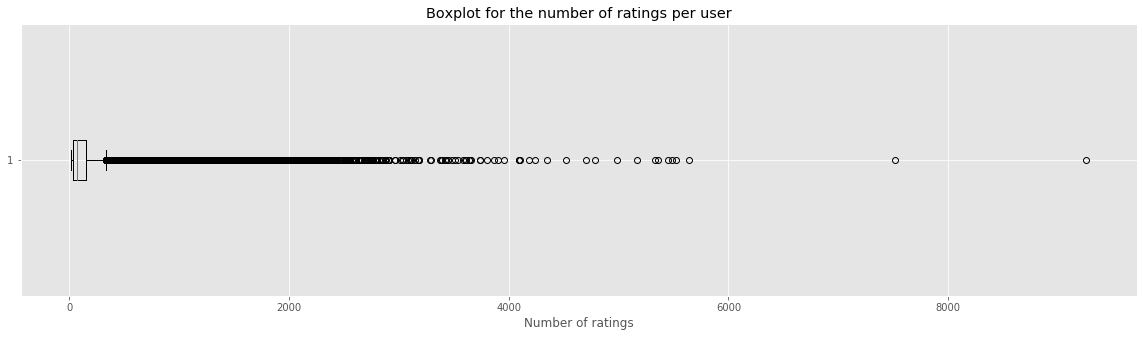

In [25]:
fig, ax = plt.subplots(figsize=(20,5))
ax.set_title('Boxplot for the number of ratings per user')
ax.set_xlabel("Number of ratings")
plot_users = ax.boxplot(rating_per_user, vert=False)

In [26]:
print(f"The median of the number of ratings per user is {np.median(rating_per_user)} ratings")

The median of the number of ratings per user is 68.0 ratings


Thus, with a low median compared to the mean together with the boxplot, we can see that the majority of users will rate only a few movies. Some outliers exists especially with a high number of ratings, and they shift the mean toward a higher number of ratings.

### Movie

Let's focus on the movies now. Our first expectation would be that blockbusters will have a lot of ratings because they have a lot of audience. And some movies will have really a few because they are in a less popular genre or treat a really specific subject.

In [27]:
count_per_movie = data.map(lambda rating : (rating["movieId"],1))
count_per_movie = count_per_movie.reduceByKey(lambda a,b : a+b).sortByKey()
rating_per_movie = np.asarray(count_per_movie.map(lambda u : u[1]).collect())

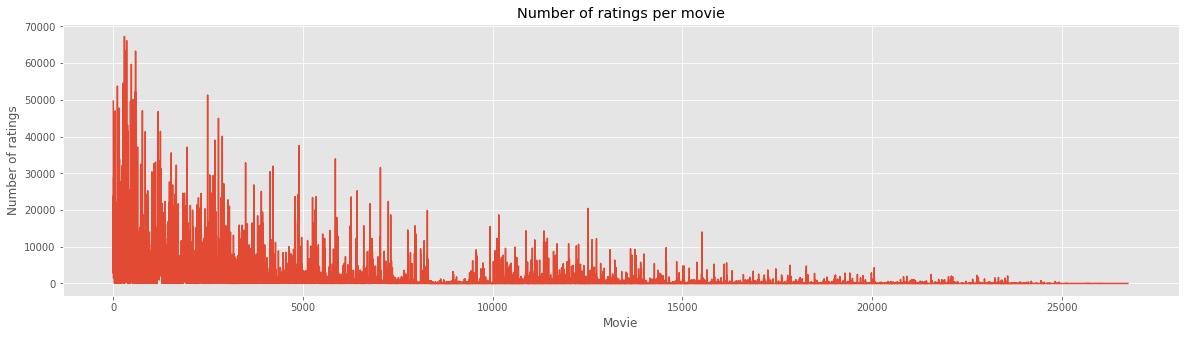

In [28]:
fig, ax = plt.subplots(figsize=(20,5))
ax.set_title('Number of ratings per movie')
ax.set_ylabel("Number of ratings")
ax.set_xlabel("Movie")
plot_movies = ax.plot(rating_per_movie)

Note that the values on the x axis of this plot is not the movieId. This is because, as opposed to userId who range from 0 to #users, the movieIds can take values that are way higher than the number of movies. Thus we don't have a nice scale so we just plot the number of ratings for each movies without giving the one to one mapping to their ids.

In [29]:
movie_mean = rating_per_movie.mean()
movie_std = rating_per_movie.std()
print(f"There is {len(rating_per_movie)} movies. The mean number of ratings per movie is {movie_mean} and it has a standard deviation of {movie_std}")

There is 26744 movies. The mean number of ratings per movie is 747.8411232425965 and it has a standard deviation of 3085.7605755779364


We can see that the average number of ratings per movie is higher than per user. Which makes sense because there is less movies so they will be watched by a lot of users. We can see that the std is also higher, by a lot! Thus there must be a lot more of outliers, i.e. some films with a lot of ratings (top of box office probably) or with only a few. Let's see the boxplot :

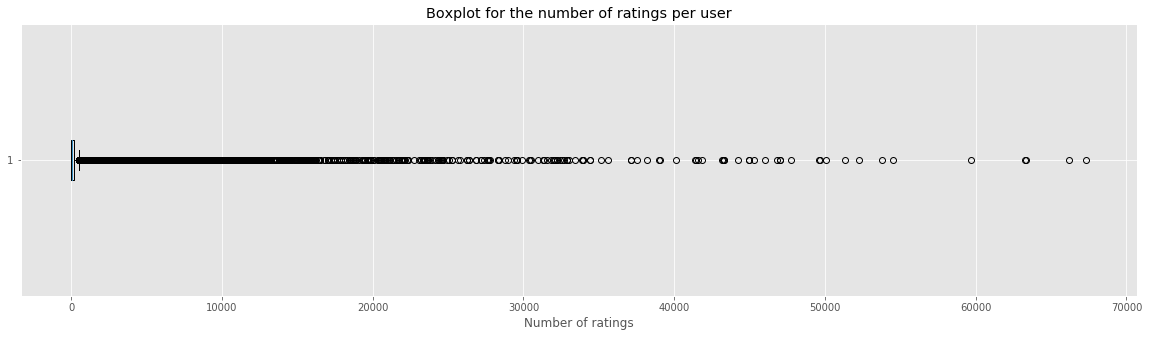

In [30]:
fig, ax = plt.subplots(figsize=(20,5))
ax.set_title('Boxplot for the number of ratings per user')
ax.set_xlabel("Number of ratings")
plot_users = ax.boxplot(rating_per_movie, vert=False)

In [31]:
print(f"The median of the number of ratings per movie is : {np.median(rating_per_movie)}")

The median of the number of ratings per movie is : 18.0


We can see that most of the the movies has a moderate number of ratings, but there is some movies with a huge number of ratings, which shifts the mean toward something higher than the median. Let's see what type of films receive a lots of ratings:

In [32]:
top_5_most_rated_movies = count_per_movie.takeOrdered(5, key = lambda x : -x[1])

To retrieve the movies'names we will use the file movies.txt which contains infos on every movies based on their movieId. This will be usefull later for part **3.2.2**

In [82]:
movies_metadata = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
movie_title_map = dict(movies_metadata.map(lambda m : (m["movieId"],m["title"])).collect())

In [34]:
for m in top_5_most_rated_movies:
    print(movie_title_map[m[0]])

Pulp Fiction (1994)
Forrest Gump (1994)
Shawshank Redemption, The (1994)
Silence of the Lambs, The (1991)
Jurassic Park (1993)


These movies are huge blockbusters, so it is not surprising that these are the ones that have a lot of ratings. 

It is great because the results are consistent with our expectations. Except that we thought that they would have been more outliers with a really low number of ratings, where in the data it seems that the lower end is rather "uniform".

**Q)** Is the number of ratings balanced uniformly across users and movies?

**A)** We can clearly see that we are far away from a uniform distribution of ratings for both users and movies, especially for movies.

## Ex 3.5)

So Jérémy Baffou rated some movies he has seen:

In [35]:
rate_movies.main()

Please rate the following movies.
1 (worst) -- 5 (best), or 0 if not seen

Toy Story (1995)
Adventure, Animation, Children, Comedy, Fantasy
your rating: 5

Independence Day (1996)
Action, Adventure, Sci-Fi, Thriller
your rating: 0

Dances with Wolves (1990)
Adventure, Drama, Western
your rating: 0

Star Wars: Episode VI - Return of the Jedi (1983)
Action, Adventure, Sci-Fi
your rating: 5

Mission: Impossible (1996)
Action, Adventure, Mystery, Thriller
your rating: 4

Ace Ventura: Pet Detective (1994)
Comedy
your rating: 0

Die Hard: With a Vengeance (1995)
Action, Crime, Thriller
your rating: 5

Batman Forever (1995)
Action, Adventure, Comedy, Crime
your rating: 0

Pretty Woman (1990)
Comedy, Romance
your rating: 0

Men in Black (1997)
Action, Comedy, Sci-Fi
your rating: 4

Dumb & Dumber (1994)
Adventure, Comedy
your rating: 0

Successfully saved 5 ratings in `my-ratings.txt`
Your user ID: 138494


In [36]:
!hdfs dfs -put my-ratings.txt

put: `my-ratings.txt': File exists


In [37]:
my_ratings = sc.textFile("my-ratings.txt").map(json.loads)

In [38]:
data_updated = data.union(my_ratings)

In [39]:
N = data_updated.count()

We will have to split the dataset into two partitions: training and validation sets. The repartition is respectively 80% and 20%. We base our partition cretarion on the time stamps : each rating whose time stamp last digit is between 0 and 7 (counted) it goes in the training set, the rest goes to the validation set. (The underlying assumption is that the last digit of the time stamps is uniformly distributed so that we have a 80/20 repartition).

In [40]:
training_set = data_updated.filter(lambda r : r["timestamp"]%10 < 8)

In [41]:
validation_set = data_updated.filter(lambda r : r["timestamp"]%10 >= 8)

**Bonus Step**

We just check that the assumption of uniform distribution over last digit is true:

In [42]:
last_digit_count = data_updated.map(lambda r : (r["timestamp"]%10,1)).reduceByKey(lambda a,b : a+b).map(lambda t : (t[0],t[1]/N)).collect()
last_digit_count

[(0, 0.09998246023503285),
 (1, 0.10002930960725126),
 (2, 0.0999604605298289),
 (3, 0.10001395981293851),
 (4, 0.10006530912485773),
 (5, 0.09999456007289502),
 (6, 0.09994416074824597),
 (7, 0.09994621072077634),
 (8, 0.09999886001527579),
 (9, 0.10006470913289763)]

This is indeed a "near uniform" distribution!

## Ex 3.6)

First of all, let's compute the global average rating for a movie:

In [43]:
global_average = training_set.map(lambda r : r["rating"]).reduce(lambda a,b : a+b)/N

In [44]:
print(f"The global average of ratings is {global_average}")

The global average of ratings is 2.8201894344615783


Now we have to compute the biases coefficients for each users and each movies. There is several ways to do it but we chose the following. 

First of all we had to decide for a default value for these biases. We chose 0 as if we have no info for a particular user or movie, we don't want to bias our prevision. Then to make things computationnaly efficient, we decided to create dictionnaries which maps users (movies) to their bias. As the operation of checking if a key is in a dictionnary is the cost of checking the hashing value of the key it is really efficient. We could also have done lists whose indexes would have been user and movie ids. But the problem of the "not consistent" scale of the movie ids make it harder to create such a list.

We start with the **biases for the users** :

In [45]:
alpha_u = training_set.map(lambda r : (r["userId"],np.asarray([r["rating"]-global_average,1]))).reduceByKey(lambda a,b : a+b).map(lambda t : (t[0],t[1][0]/t[1][1])).collect()

In [46]:
alpha_u_dict = dict(alpha_u)

In [47]:
def user_bias(user_id):
    if user_id in alpha_u_dict:
        return alpha_u_dict[user_id]
    return 0

Now the **biases for movies**:

In [48]:
beta_m = training_set.map(lambda r : (r["movieId"],np.asarray([r["rating"]-global_average-user_bias(r["userId"]),1]))).reduceByKey(lambda a,b : a+b).map(lambda t : (t[0],t[1][0]/t[1][1])).collect()

In [49]:
beta_m_dict = dict(beta_m)

In [50]:
def movie_bias(movie_id):
    if movie_id in beta_m_dict:
        return beta_m_dict[movie_id]
    return 0

We also create a function to compute our rating estimator. It will be more convenient for map functions later.

In [51]:
"""
We take the user and movie IDs, and return the estimated rating for this pair according to the given formula
"""
def r_estimate(u,m):
    return global_average + user_bias(u) + movie_bias(m)

Note that we made an implentation choice which is to have some global variables (global_average, the biases dictionarries, ...) because it was more convenient to work with functions with a low number of argument rather than passing every parameter to each function. It would have been more consistent but as we do a lot of map, reduce an so on, it was really more convenient to have a function with only two parameters.  

The model has as parameters the global average, the biases for users and the biases for movies which gives:

In [52]:
print(f"The model has {1+len(alpha_u_dict)+len(beta_m_dict)} parameters") # global average + alphas for users with ratings + betas for movies with ratings

The model has 164320 parameters


#### Lets compute the estimated ratings for the entire validation set:

In [53]:
estimated_rating = validation_set.map(lambda r : {"movieId" : r["movieId"], "userId" : r["userId"], "rating": r_estimate(r["userId"], r["movieId"])})

In [54]:
estimated_rating.take(10)

[{'movieId': 32, 'userId': 1, 'rating': 4.063861913493075},
 {'movieId': 318, 'userId': 1, 'rating': 4.545559969291732},
 {'movieId': 337, 'userId': 1, 'rating': 3.9576628834893786},
 {'movieId': 924, 'userId': 1, 'rating': 4.088474345829363},
 {'movieId': 1089, 'userId': 1, 'rating': 4.213544616392077},
 {'movieId': 1136, 'userId': 1, 'rating': 4.287357667635263},
 {'movieId': 1246, 'userId': 1, 'rating': 4.0694082516926935},
 {'movieId': 1350, 'userId': 1, 'rating': 3.819252843392894},
 {'movieId': 1358, 'userId': 1, 'rating': 4.142904219276587},
 {'movieId': 1920, 'userId': 1, 'rating': 3.129217093048491}]

In [55]:
validation_set.take(10)

[{'movieId': 32, 'userId': 1, 'timestamp': 1112484819, 'rating': 3.5},
 {'movieId': 318, 'userId': 1, 'timestamp': 1112484798, 'rating': 4.0},
 {'movieId': 337, 'userId': 1, 'timestamp': 1094785709, 'rating': 3.5},
 {'movieId': 924, 'userId': 1, 'timestamp': 1094785598, 'rating': 3.5},
 {'movieId': 1089, 'userId': 1, 'timestamp': 1112484669, 'rating': 3.5},
 {'movieId': 1136, 'userId': 1, 'timestamp': 1112484609, 'rating': 3.5},
 {'movieId': 1246, 'userId': 1, 'timestamp': 1094785759, 'rating': 3.5},
 {'movieId': 1350, 'userId': 1, 'timestamp': 1094786158, 'rating': 3.5},
 {'movieId': 1358, 'userId': 1, 'timestamp': 1112485419, 'rating': 4.0},
 {'movieId': 1920, 'userId': 1, 'timestamp': 1112486098, 'rating': 3.5}]

The prediction seems pretty good, we tends to rate movies too well. But as we take only 10 results it is absolutely not statistically significant (it was just to have an idea of what the predicted ratings look like).

## Ex 3.7)

Let's implement our error function. We decided to uses operations over a dataframe because it was easier to group features correctly rather than to work with the usual RDD's operations.

In [56]:
"""
This function takes as argument the RDD with the expected ratings and compute the average of each user’s root
meansquare error over the validation set.
To do so we first reformat the RDDs, merge them and reduce by key to compute the squared difference for each 
(user, movie) pair. Then we create a dataframe based on these differences and performs grouping and mathematical
opperations to compute our error, according to the given formula.
"""
def error(RDD):
    new_val = validation_set.map(lambda x : ((x["userId"],x["movieId"]),x["rating"]))
    new_RDD = RDD.map(lambda x : ((x[0],x[1]),x[2]))
    squared_diff = new_RDD.union(new_val).reduceByKey(lambda a,b : float(np.square(np.asarray([a - b]))[0]))
    reformat_squared_diff = squared_diff.map(lambda t : (t[0][0],t[0][1],t[1]))
    df = spark.createDataFrame(data=reformat_squared_diff, schema=["user","movie","squared_diff_rating"])
    df_user = df.groupBy("user").avg("squared_diff_rating")
    df_user_sqrt =  df_user.withColumn("avg(squared_diff_rating)", sqrt("avg(squared_diff_rating)"))
    error_df = df_user_sqrt.agg({"avg(squared_diff_rating)" : "avg"})
    return error_df.collect()[0][0]

In [57]:
error_basic_estimator = error(estimated_rating.map(lambda x : (x["userId"],x["movieId"],x["rating"])))

In [58]:
print(f"The error using the basic model in section 3.6 gives an error of : {error_basic_estimator}")

The error using the basic model in section 3.6 gives an error of : 0.8670167130689688


# 3.2.2

Before jumping into the exercices we decided to check the number of genre of movies. The ALS model tries to capture some shared features between similar items (here movies) and the number of seach features is the rank of the matrices that it tries to optimize. The rank is an hyperparameter of the model and can be optimized using cross-validation. Here we are asked to choose one between 5 and 25, we decided that the number of genre could be a good guess to the rank value of the model:

### Number of genre of movies

In [60]:
def compute_genre_list(movie_RDD):
    formatted_rdd = movie_RDD.flatMap(lambda a : a["genres"])
    genre_count = formatted_rdd.map(lambda a : (a,1)).reduceByKey(lambda a,b : a+b).collect()
    return genre_count

movies_genre_count = compute_genre_list(movies_metadata)

print(f"There is {len(movies_genre_count)} different types of movies according to their genre, and they are : {movies_genre_count}")

There is 20 different types of movies according to their genre, and they are : [('Drama', 13344), ('Romance', 4127), ('Western', 676), ('Action', 3520), ('Sci-Fi', 1743), ('Children', 1139), ('Documentary', 2471), ('Thriller', 4178), ('Fantasy', 1412), ('Musical', 1036), ('Horror', 2611), ('IMAX', 196), ('Adventure', 2329), ('Animation', 1027), ('Comedy', 8374), ('Crime', 2939), ('Mystery', 1514), ('War', 1194), ('Film-Noir', 330), ('(no genres listed)', 246)]


## 3.8)

We decided on a rank of 19. because we will try to capture these different genres of movies (or maybe other more important factor but 19 is a good basis).  We put 19 because the last genre is not a real one. Like this we capture several factors, thus we have a better precision in our recommendations, but we still have not too much of them so that the computation is pretty fast.

In [61]:
rank = len(movies_genre_count)-1

In [62]:
"""
Basic loop which trains an ALS model with the given rank and lambda_ and over the training set 
and then compute the average mean square error over user with respect to the given validation set
"""
def model_loop(training_data, validation_data, rank, lambda_=0.01):
    recommender = ml.ALS()
    trained_model = recommender.train(training_data.map(lambda d : (d["userId"], d["movieId"], d["rating"])), rank, lambda_=lambda_)
    predictions = trained_model.predictAll(validation_data.map(lambda d : (d["userId"], d["movieId"])))
    formated_pred = predictions.map(lambda r : (r[0],r[1],r[2]))
    error_pred = error(formated_pred)
    return error_pred

In [63]:
error_als = model_loop(training_set, validation_set, rank, lambda_=0.0001)

In [64]:
print(f"Error on validation set using ALS model with lambda = 0.0001 and rank = {rank} : {error_als}")

Error on validation set using ALS model with lambda = 0.0001 and rank = 19 : 1.0851037079807313


We have a less accurate model than the one created in ex **3.6**. The reason is that our lambda_ is too low, so the model overfits on the training data and then it doesn't generalize well on the validation data.

In [65]:
error_als_2 = model_loop(training_set, validation_set, rank, lambda_=10.0)

In [66]:
print(f"Error on validation set using ALS model with lambda = 10 and rank = {rank} : {error_als_2}")

Error on validation set using ALS model with lambda = 10 and rank = 19 : 3.7457235097876724


Here the problem is that the regularization factor is too height so we generalize too much (inverse of overfitting). We don't let the model become too specific, but by staying too general we can't have precise predictions.

Lambda weights the sum of the "norm" of the matrices P and Q which represents how users like a certain feature and how items are related to certain features respectively. Thus the heigher the lambda is, the higher we penalize big value for elements if P and Q. It avoids overfitting.

The problem is that I have no idea how to optimize with respect to lambda???

In [93]:
#---->
optimal_lambda = 0.055# replace with the correct value
optimal_lambda = find_hyperparameter(np.linspace(0.06,0.08,num=20))

# Ex 3.9)

The dictionnary creation has been made in ex **3.4**. Now we will train the ALS model with the optimal lambda_ we found previously and use the built in function recommendProducts to recommend movies to user 123 and to Jérémy Baffou (user 138494)

In [87]:
model = ml.ALS()
model = model.train(training_set.map(lambda d : (d["userId"], d["movieId"], d["rating"])), rank, lambda_=optimal_lambda)

In [88]:
user123_rec_movies = model.recommendProducts(123,10)

print("The user 123 should probably like the following movies :")
print(f"{list(map(lambda r : movie_title_map[r[1]],user123_rec_movies))}")

The user 123 should probably like the following movies :
['Scorpio Rising (1964)', 'Carmina and Amen (Carmina y amén) (2014)', 'Cremaster 5 (1997)', 'Trinity: Gambling for High Stakes (Odds and Evens) (Pari e dispari) (1978)', 'Hamoun (1990)', 'Jim Jefferies: Alcoholocaust (2010)', 'Q (2011)', 'Leap Year (Año bisiesto) (2010)', 'House of Sand (Casa de Areia) (2005)', 'Klip (Clip) (2012)']


The user seems to like asian movies and what we called anime (i.e. japanese animation movies). The drama genre also comes regularly.

In [89]:
myself_rec_movies = model.recommendProducts(138494,10)

print("According to the model I should probably like the following movies :")
print(f"{list(map(lambda r : movie_title_map[r[1]],myself_rec_movies))}")

According to the model I should probably like the following movies :
["Craig Ferguson: A Wee Bit o' Revolution (2009)", 'Patton Oswalt: Tragedy Plus Comedy Equals Time (2014)', 'Tom Segura: Completely Normal (2014)', 'Class of 92, The (2013)', 'Patton Oswalt: My Weakness Is Strong (2009)', 'Kevin Smith: Too Fat For 40 (2010)', 'Chameleon (Kaméleon) (2008)', 'Cat Came Back, The (1988)', 'Kevin Smith: Sold Out - A Threevening with Kevin Smith (2008)', 'Mimino (1977)']


I saw some of the movies and they were indeed great, I will watch some of them to check if our model is truely accurate :)

# 3.10

Let's first train our 2D rank model:

In [98]:
model_2d = ml.ALS()
model_2d = model_2d.train(training_set.map(lambda d : (d["userId"], d["movieId"], d["rating"])), 2, lambda_=optimal_lambda)

Then we open the pickle because we are only interested in the movies that it contains for the visualization

In [95]:
with open("selected-movies.pickle", "rb") as f:
    movies_pickle = pickle.load(f, encoding="utf-8")
movies_pickle_set = set(map(lambda t : t[0],movies_pickle))

Now we can take the features of the model for these movies

In [99]:
features = model_2d.productFeatures().filter(lambda t : t[0] in movies_pickle_set).map(lambda t : (t[1][0], t[1][1], movie_title_map[t[0]])).collect()

Finally we can plot our data!

In [103]:
# Continuous colors
from matplotlib.colors import rgb2hex 
cmap = plt.get_cmap('viridis')
def val2rgb(val):
    return rgb2hex(cmap(val)[:3])

source = ColumnDataSource(
    data={
        "x": [x[0] for x in features],
        "y": [x[1] for x in features],
        "name": [x[2] for x in features],
        "color": [val2rgb(x) for x in np.linspace(0,1,num=len(features))],
    })

hover = HoverTool(
    tooltips=[
        ("Name", "@name"),
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(plot_width=960, plot_height=360, tools=tools, title="2d representation of the movies in the pickle")
p.circle("x", "y", source=source, size=20, color="color", alpha=0.5)
show(p, notebook_handle=True)

## Hyper parameter optimization

Here we implementend a really basic algorithm to find the best lambda_. We could have used specific libraries (such as scikit learn, scipy or even the pyspark ml tuning library) but the problem is if we wanted to conserve our implementation of the error and the data splitting we used, it was not convenient to use them (and sometimes impossible due to compatibility problems). 

In [30]:
grid = np.linspace(0.06,0.08,num=20)

In [79]:
def find_hyperparameter(grid):
    results = dict(list(map(lambda l : (l,-1), grid)))
    for lambda_parameter in grid:
        results[lambda_parameter] = model_loop(training_set,validation_set, rank, lambda_=lambda_parameter)
    return results

def binary_search_hyperparameter(start,init_step_size,alpha,max_iter):
    best_lambda = 0.0
    temp_lambda = start
    previous_error = np.inf
    direction_indicator = 1
    step_size = init_step_size
    for i in range(max_iter):
        new_error = model_loop(training_set,validation_set, rank, lambda_=temp_lambda)
        if previous_error > new_error:
            previous_error = new_error
            best_lambda = temp_lambda
        else:
            direction_indicator = -direction_indicator
        step_size = step_size*alpha
        temp_lambda = temp_lambda + direction_indicator * step_size
    return best_lambda

In [31]:
lambda_search = find_hyperparameter(grid)

In [32]:
lambda_search

{0.06: 0.8137485888535594,
 0.061052631578947365: 0.8075418531202803,
 0.06210526315789473: 0.8000921007240045,
 0.06315789473684211: 0.8230385943423217,
 0.06421052631578947: 0.8111648966214823,
 0.06526315789473684: 0.8200058733707563,
 0.06631578947368422: 0.8098857058554201,
 0.06736842105263158: 0.8055657482679777,
 0.06842105263157895: 0.8071507296158312,
 0.06947368421052631: 0.8186663082105397,
 0.07052631578947369: 0.8116685017136996,
 0.07157894736842105: 0.816317290468767,
 0.07263157894736842: 0.815080851929041,
 0.0736842105263158: 0.81327359934284,
 0.07473684210526316: 0.8184009059602554,
 0.07578947368421053: 0.8191551741924309,
 0.07684210526315789: 0.8112788674510727,
 0.07789473684210527: 0.8042109810702114,
 0.07894736842105263: 0.8050630448515979,
 0.08: 0.8093184898281707}

In [66]:
lambda_search

{0.01: 0.8689030703413655,
 0.020000000000000004: 0.8466450185854596,
 0.030000000000000006: 0.8316957906397796,
 0.04000000000000001: 0.8231167910359469,
 0.05000000000000001: 0.8170088546470139,
 0.06000000000000001: 0.8140104561402434,
 0.07: 0.8055955617807303,
 0.08: 0.8172017632285095,
 0.09000000000000001: 0.8220404119817021,
 0.1: 0.820769172642735}